# Parameter exploration of cortical network model

We explored traveling waves in a cortical network model for a range of intrinsic frequencies, global coupling scalings, and conduction speeds.

In [40]:
import pickle
import os
import yaml
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import spearmanr, kstest, pearsonr
from scipy.signal import hilbert

from palettable.scientific.sequential import Turku_20, Davos_20, Tokyo_20, Batlow_20, LaPaz_20
from palettable.scientific.diverging import Lisbon_20
from palettable.cmocean.sequential import Ice_20

from modules.visualization import *

cmap_waves = Ice_20.mpl_colormap

cmap_corr = Lisbon_20.mpl_colormap
cmap_corr.set_bad('white')

cmap_fq = LaPaz_20.mpl_colormap

cmap_pwaves = sns.color_palette("rocket", as_cmap=True)
cmap_pwaves.set_bad('white')
cmap_gwaves = sns.color_palette("mako", as_cmap=True)
cmap_gwaves.set_bad('white')


plt.rcParams['image.cmap'] = 'cividis'
dpi = 300
page_width = 2244  # pxl at 300 dpi

In [41]:
# specify paths
data_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data"
output_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/40_simulations"
figure_path = "/Users/dk/Documents/Charite/PhD/travelingwaves/data/40_results/figures"

In [42]:
# Load Sensor Geometry
# --------------------
# load schaefer surface mesh
with open(os.path.join(data_path, "connectomes/Schaefer2018_HCP_S900/schaefer_surface_mesh.pkl"), 'rb') as f:
    surface_mesh = pickle.load(f)
    
v_lh = surface_mesh['vertices_lh']
f_lh = surface_mesh['faces_lh']
v_rh = surface_mesh['vertices_rh']
f_rh = surface_mesh['faces_rh']
number_of_regions_per_hemi = v_lh.shape[0]
number_of_regions = number_of_regions_per_hemi * 2

# combine left and right hemispheres
v_lh[:,0] = v_lh[:,0] - (v_lh[:,0].max() - v_lh[:,0].min())

v = np.concatenate([v_lh, v_rh])
v[:,0] = v[:,0]
f = np.concatenate([f_lh, f_rh+number_of_regions_per_hemi])

### Configuration

In [43]:
# Read Configuration
configuration_path = "../../configuration/40_configuration.yaml"
configuration_analysis_path = "../../configuration/40_analysis_configuration.yaml"
try:
    with open(configuration_path, "r") as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.BaseLoader)
        
    with open(configuration_analysis_path, "r") as ymlfile:
        config_analysis = yaml.load(ymlfile, Loader=yaml.BaseLoader)
except BaseException as e:
    print("Error: Specify correct path to yaml configuration file.")
    raise

experiment_id = config["experiment_id"]

# statistics
significance_level = float(config_analysis["significance_level"])

# Simulation Parameters
# ---------------------
integration_step_size = float(config["integration_step_size"])  # ms
simulation_duration = float(config["simulation_duration"])  # ms
initial_transient = float(config["initial_transient"])  # ms

downsampling_factor = float(config_analysis["downsampling_factor"])  # a.u.
integration_step_size_downsampled = integration_step_size * downsampling_factor
number_of_timesteps_downsampled = int((simulation_duration-initial_transient)/integration_step_size_downsampled)

In [44]:
# Parameters to Explore
# ---------------------
sim_id_start, sim_id_end, sim_id_step = np.array(config["simulation_id"], dtype=int)
simulation_ids = np.arange(sim_id_start, sim_id_end, sim_id_step)

intrinsic_frequency = np.array(config["intrinsic_frequency"], dtype=float)  # Hz

coupling_strength_start, coupling_strength_end, coupling_strength_steps = np.array(config["coupling_strength"], dtype=float)  # a.u. [start_id, end_id, number_of_steps]
coupling_strength = np.logspace(coupling_strength_start, coupling_strength_end, int(coupling_strength_steps))

conduction_speed_start, conduction_speed_end, conduction_speed_steps = np.array(config["conduction_speed"], dtype=float)
conduction_speed = np.linspace(conduction_speed_start, conduction_speed_end, int(conduction_speed_steps))

## Wave stats

In [45]:
wave_stats = []
guided_wave_stats = []

counter = 0
for simulation_id in simulation_ids:
    for frequency_idx, freq in enumerate(intrinsic_frequency):
        for coupling_strength_idx, coupling in enumerate(coupling_strength):
            for conduction_speed_idx, speed in enumerate(conduction_speed):
                wave_mask_div_lh = np.load(os.path.join(data_path, f"{experiment_id}_analysis", f"{experiment_id}_wave_mask_div_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))
                wave_mask_div_rh = np.load(os.path.join(data_path, f"{experiment_id}_analysis", f"{experiment_id}_wave_mask_div_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))
                proportion_waves_lh = 100 * np.sum(wave_mask_div_lh) / number_of_timesteps_downsampled
                proportion_waves_rh = 100 * np.sum(wave_mask_div_rh) / number_of_timesteps_downsampled

                # there is a bug in the Kuramoto model of TVB that does not normalize the interaction term appropriately
                # therefore, the coupling needs to be multiplied by the number of regions
                wave_stats.append([simulation_id, freq, coupling*1000, speed, proportion_waves_lh, proportion_waves_rh])

                corr_lh = np.load(os.path.join(data_path, f"{experiment_id}_analysis_potentials", f"{experiment_id}_corr_div_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))
                corr_rh = np.load(os.path.join(data_path, f"{experiment_id}_analysis_potentials", f"{experiment_id}_corr_div_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))

                guided_waves_lh = np.load(os.path.join(data_path, f"{experiment_id}_analysis_potentials", f"{experiment_id}_guidedwaves_mask_div_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))
                guided_waves_rh = np.load(os.path.join(data_path, f"{experiment_id}_analysis_potentials", f"{experiment_id}_guidedwaves_mask_div_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))

                proportion_guided_waves_lh = 100 * np.sum(guided_waves_lh & wave_mask_div_lh) / wave_mask_div_lh.sum() if np.any(guided_waves_lh & wave_mask_div_lh) else 0.0
                proportion_guided_waves_rh = 100 * np.sum(guided_waves_rh & wave_mask_div_lh) / wave_mask_div_rh.sum() if np.any(guided_waves_rh & wave_mask_div_rh) else 0.0

                mean_corr_lh = corr_lh[guided_waves_lh & wave_mask_div_lh].mean() if np.any(guided_waves_lh & wave_mask_div_lh) else 0.0
                mean_corr_rh = corr_rh[guided_waves_rh & wave_mask_div_rh].mean() if np.any(guided_waves_rh & wave_mask_div_rh) else 0.0

                guided_wave_stats.append([simulation_id, freq, coupling*1000, speed, 
                                          proportion_guided_waves_lh, 
                                          proportion_guided_waves_rh,
                                          mean_corr_lh,
                                          mean_corr_rh

                                         ])

# build dataframe
wave_stats = pd.DataFrame(wave_stats, columns=['simulation id', 'frequency', 'coupling strength', 'conduction speed', 'proportion of waves (left)', 'proportion of waves (right)'])

# waves
# -----
# average across simulations
wave_stats_avg = wave_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()

# guided waves
# ------------
# build dataframe
guided_wave_stats = pd.DataFrame(guided_wave_stats, columns=['simulation id', 'frequency', 'coupling strength', 'conduction speed', 
                                                             'proportion guided waves (left)', 
                                                             'proportion guided waves (right)',
                                                             'correlation (left)',
                                                             'correlation (right)'
                                                            ])

In [46]:
# average across simulations
guided_wave_stats_avg = guided_wave_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()


# Aggregate metrics
# -----------------
waves_proportion_lh = []
waves_proportion_rh = []
guided_waves_proportion_lh = []
guided_waves_proportion_rh = []
guided_waves_corr_lh = []
guided_waves_corr_rh = []
for i, fq in enumerate(intrinsic_frequency):
    # waves proportion per frequency
    waves_proportion_lh.append(wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                    columns='conduction speed', 
                                                                                    values='proportion of waves (left)', 
                                                                                    dropna=False)
                              )
    waves_proportion_rh.append(wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                    columns='conduction speed', 
                                                                                    values='proportion of waves (right)', 
                                                                                    dropna=False)
                              )
    
    # guided waves proportion per frequency
    guided_waves_proportion_lh.append(guided_wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                                  columns='conduction speed', 
                                                                                                  values='proportion guided waves (left)', 
                                                                                                  dropna=False)
                                     )
    guided_waves_proportion_rh.append(guided_wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                                  columns='conduction speed', 
                                                                                                  values='proportion guided waves (right)', 
                                                                                                  dropna=False)
                                     )
    
    # guided waves correlation per frequency
    guided_waves_corr_lh.append(guided_wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                            columns='conduction speed', 
                                                                                            values='correlation (left)', 
                                                                                            dropna=False)
                               )
    guided_waves_corr_rh.append(guided_wave_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                            columns='conduction speed', 
                                                                                            values='correlation (right)', 
                                                                                            dropna=False)
                               )

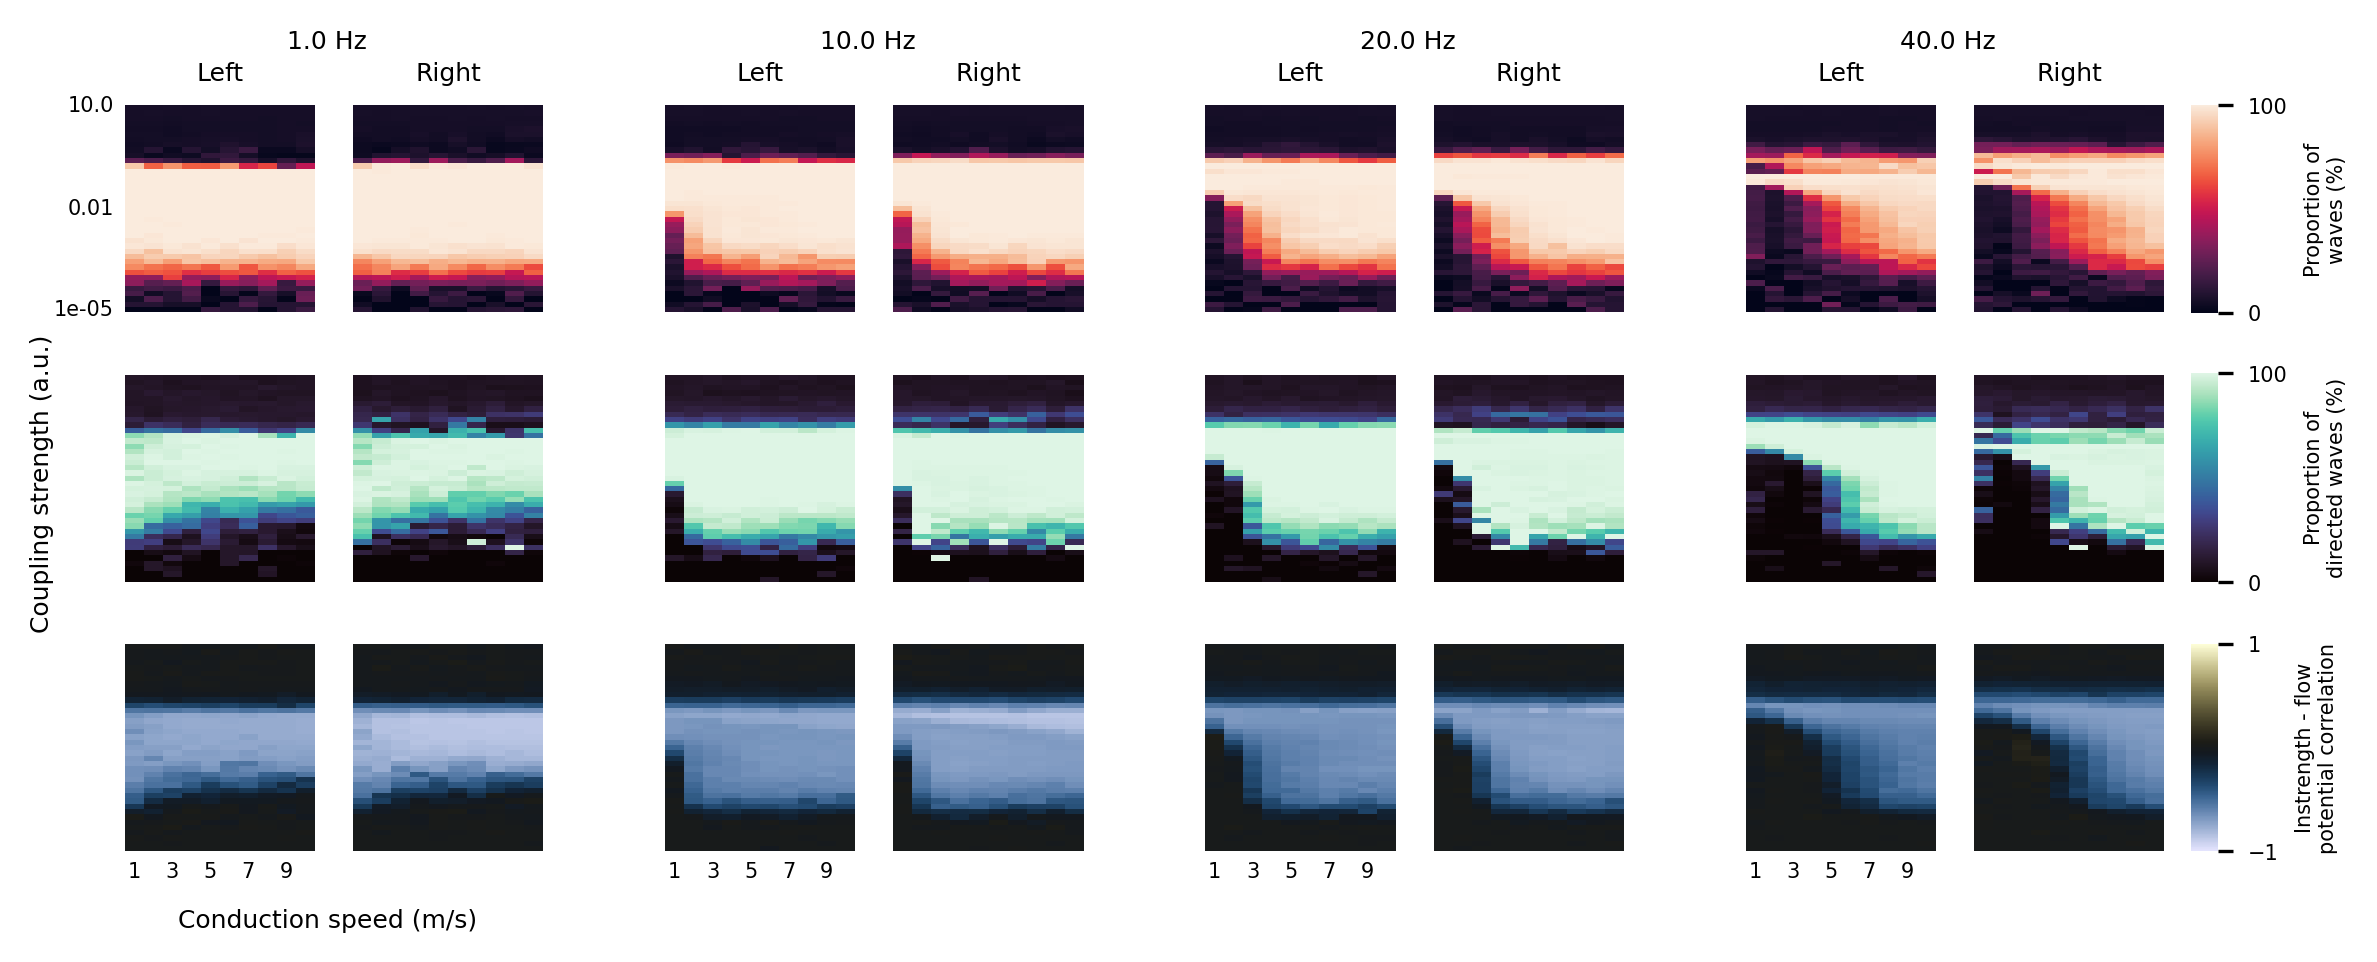

In [15]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

# create figure
fig = plt.figure(figsize=(18.3*cm, 8.*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency))

vmax_waves = 100
vmax_guided_waves = 100
vmax_corr = 1
vmin_corr = -1
for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=.98)
    
    ax = subfigs[i].subplots(3,2)
    p = sns.heatmap(waves_proportion_lh[i], vmin=0, vmax=vmax_waves, cmap=cmap_pwaves, cbar=None, ax=ax[0,0])
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set_title('Left', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(waves_proportion_rh[i], vmin=0, vmax=vmax_waves, cmap=cmap_pwaves,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.68, .05, .22]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Proportion of\nwaves (%)', 'ticks': [0, vmax_waves]} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[0,1])
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=[])
    p.set_title('Right', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    subfigs[i].subplots_adjust(top=0.9, hspace=0.3)
        
    p = sns.heatmap(guided_waves_proportion_lh[i], vmin=0, vmax=vmax_guided_waves, cmap=cmap_gwaves, cbar=None, ax=ax[1,0])
    p.set(xlabel=None, ylabel=None, xticklabels=[])
    p.set_yticklabels([])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(guided_waves_proportion_rh[i], vmin=0, vmax=vmax_guided_waves, cmap=cmap_gwaves,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.395, .05, .221]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Proportion of\ndirected waves (%)', 'ticks': [0, vmax_guided_waves]} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[1,1])
    p.set(xlabel=None, xticklabels=[], ylabel=None, yticklabels=[])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)

    p = sns.heatmap(guided_waves_corr_lh[i], vmin=vmin_corr, vmax=vmax_corr, cmap=cmap_corr, cbar=None, ax=ax[2,0])
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=conduction_speed.astype(int)[::2])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(guided_waves_corr_rh[i], vmin=vmin_corr, vmax=vmax_corr, cmap=cmap_corr,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.11, .05, .22]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Instrength - flow\npotential correlation', 'ticks': [vmin_corr, vmax_corr]} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[2,1])
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=[])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    if i==0:
        subfigs[i].text(0.5, 0.03, 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.05, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'40_wave_stats.svg'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'40_wave_stats.png'), dpi=300, transparent=False, bbox_inches='tight')

In [102]:
# find maximum of instrength-wave correlation
instrength_wave_min_coords = []
instrength_wave_min_corr = []

for i, freq in enumerate(intrinsic_frequency):
    # average across hemispheres
    waves_corr = np.nanmean([guided_waves_corr_lh[i], guided_waves_corr_rh[i]], axis=0)
    instrength_wave_min_coords.append(np.unravel_index(np.nanargmin(waves_corr), waves_corr.shape))
    instrength_wave_min_corr.append(np.nanmin(waves_corr))

/var/folders/xn/1ct3chq55gz5_hwxwqddzkz80000gn/T/ipykernel_59819/63600967.py:7: RuntimeWarning: Mean of empty slice
  waves_corr = np.nanmean([guided_waves_corr_lh[i], guided_waves_corr_rh[i]], axis=0)


In [103]:
instrength_wave_min_coords, instrength_wave_min_corr

([(24, 9), (25, 9), (26, 9), (25, 9)],
 [-0.8199452609010975,
  -0.810528630283321,
  -0.7605337624374497,
  -0.6887272557019921])

### Effective frequency - Instrength correlation

Instrength - effective frequency correlation during wave episodes.

In [57]:
frequency_instrength_corr = []

for simulation_id in simulation_ids:
    for frequency_idx, freq in enumerate(intrinsic_frequency):
        for coupling_strength_idx, coupling in enumerate(coupling_strength):
            for conduction_speed_idx, speed in enumerate(conduction_speed):
                try:
                    frequency_instrength_corr_lh = float(np.load(os.path.join(data_path, f"{experiment_id}_analysis_frequency_instrength_corr", f"{experiment_id}_frequency-instrength_corr_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                    frequency_instrength_corr_rh = float(np.load(os.path.join(data_path, f"{experiment_id}_analysis_frequency_instrength_corr", f"{experiment_id}_frequency-instrength_corr_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                except:
                    # set correlation to 0 if no waves occured
                    frequency_instrength_corr_lh = 0
                    frequency_instrength_corr_rh = 0
                
                frequency_instrength_corr.append([simulation_id, freq, coupling*1000, speed,
                                                  frequency_instrength_corr_lh,
                                                  frequency_instrength_corr_rh
                                                 ])

In [58]:
# guided waves
# ------------
# build dataframe
frequency_instrength_corr_stats = pd.DataFrame(frequency_instrength_corr, columns=['simulation id', 'frequency', 'coupling strength', 'conduction speed', 
                                                                                   'frequency - instrength correlation (left)',
                                                                                   'frequency - instrength correlation (right)'
                                                                                  ])

# average across simulations
frequency_instrength_corr_stats_avg = frequency_instrength_corr_stats.groupby(['frequency', 'coupling strength', 'conduction speed'], dropna=False).mean()


# Aggregate metrics
# -----------------
frequency_instrength_corr_freq_lh = []
frequency_instrength_corr_freq_rh = []

for i, fq in enumerate(intrinsic_frequency):  
    # wave speeds per per frequency
    frequency_instrength_corr_freq_lh.append(frequency_instrength_corr_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                                                       columns='conduction speed', 
                                                                                                                       values='frequency - instrength correlation (left)',
                                                                                                                       dropna=False)
                                            )
    frequency_instrength_corr_freq_rh.append(frequency_instrength_corr_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                                                       columns='conduction speed', 
                                                                                                                       values='frequency - instrength correlation (right)',
                                                                                                                       dropna=False)
                                            )

Text(0.5, 0.98, ' ')

<Figure size 2161.42x295.276 with 0 Axes>

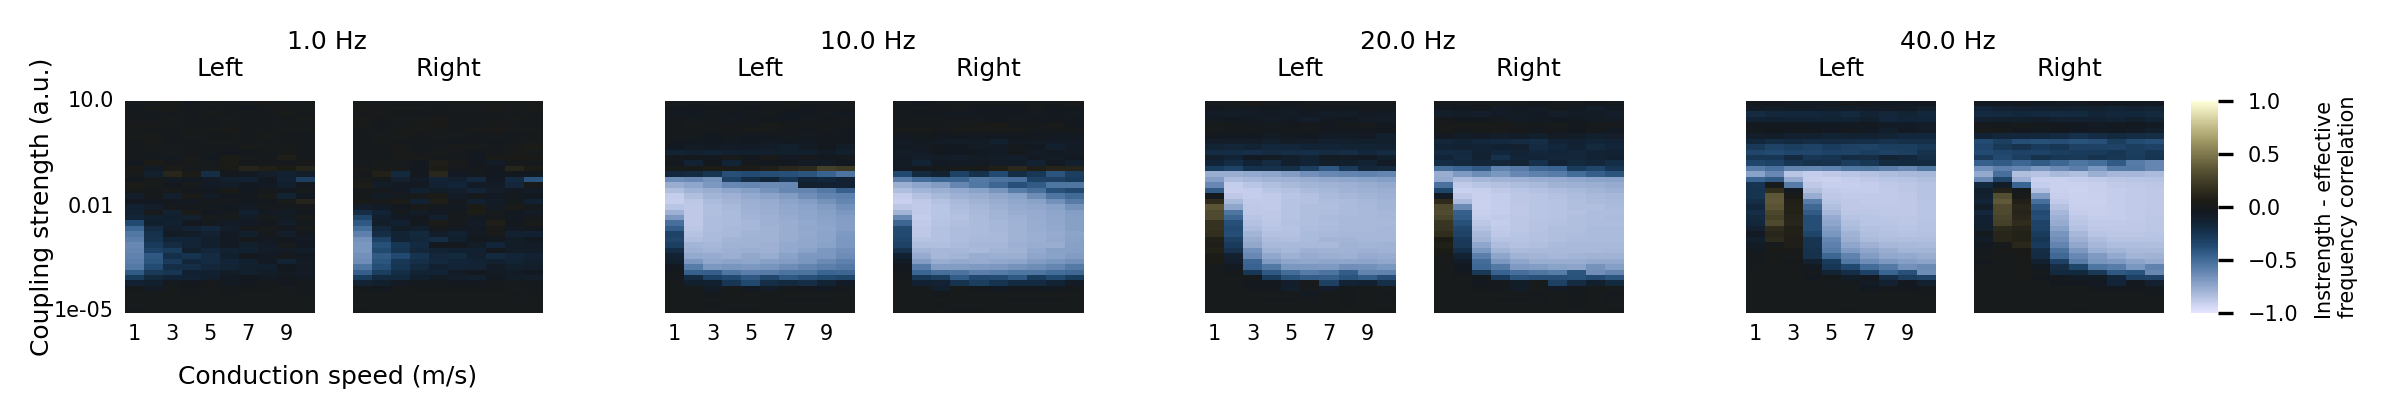

In [59]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

# create figure
fig = plt.figure(figsize=(18.3*cm, 2.5*cm), dpi=300)
fig = plt.figure(figsize=(18.3*cm, 3*cm), dpi=300)

subfigs = fig.subfigures(1,len(intrinsic_frequency))

vsym = 1
for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)

    ax = subfigs[i].subplots(1,2)
    subfigs[i].subplots_adjust(top=0.8, bottom=0.2)

    p = sns.heatmap(frequency_instrength_corr_freq_lh[i], 
                    vmin=-vsym, vmax=vsym, 
                    cmap=cmap_corr, 
                    cbar=None, 
                    ax=ax[0]
                   )
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.set_title('Left', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(frequency_instrength_corr_freq_rh[i], vmin=-vsym, vmax=vsym, cmap=cmap_corr,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.2, .05, .60]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Instrength - effective \nfrequency correlation'} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[1]
                   )
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=[])
    p.invert_yaxis()
    p.set_title('Right', y=1)
    p.tick_params(left=False, bottom=False, pad=-1)

    
    if i==0:
        subfigs[i].text(0.5, 0., 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.05, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'40_frequency_instrength_corr.svg'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'40_frequency_instrength_corr.png'), dpi=300, transparent=True, bbox_inches='tight')

In [107]:
# find maximum of instrength-frequency correlation
instrength_ef_min_coords = []
instrength_ef_min_corr = []
instrength_ef_max_coords = []
instrength_ef_max_corr = []

for i, freq in enumerate(intrinsic_frequency):
    # average across hemispheres
    freq_corr = np.nanmean([frequency_instrength_corr_freq_lh[i], frequency_instrength_corr_freq_rh[i]], axis=0)
    instrength_ef_min_coords.append(np.unravel_index(np.nanargmin(freq_corr), freq_corr.shape))
    instrength_ef_min_corr.append(np.nanmin(freq_corr))
    instrength_ef_max_coords.append(np.unravel_index(np.nanargmax(freq_corr), freq_corr.shape))
    instrength_ef_max_corr.append(np.nanmax(freq_corr))

/var/folders/xn/1ct3chq55gz5_hwxwqddzkz80000gn/T/ipykernel_59819/3063820647.py:9: RuntimeWarning: Mean of empty slice
  freq_corr = np.nanmean([frequency_instrength_corr_freq_lh[i], frequency_instrength_corr_freq_rh[i]], axis=0)


In [108]:
instrength_ef_min_coords, instrength_ef_min_corr, instrength_ef_max_coords, instrength_ef_max_corr

([(12, 0), (20, 0), (22, 1), (23, 4)],
 [-0.6472743906975627,
  -0.9026518954075816,
  -0.9054723674894699,
  -0.9070073704294817],
 [(26, 8), (26, 8), (18, 0), (19, 1)],
 [0.07509441383688284,
  0.17674520354282658,
  0.36654502618010465,
  0.39314912459649837])

# MEG-HCP Demographics

In [245]:
subjects = pd.read_csv(os.path.join(data_path, 'hcp_meg/meg_subjects.csv'))

In [247]:
# Set indicator for excluded subjects
excluded_subjects = [104012, 158136, 169040, 233326, 257845, 283543, 599671, 706040, 891667, 912447]

sub_exc_idx = np.squeeze([np.where(subjects['Subject']==sub)[0] for sub in excluded_subjects])
subjects['Excluded'] = False
subjects.loc[sub_exc_idx, 'Excluded'] = True

In [249]:
subjects[['Subject', 'Gender', 'Age', 'Excluded']]

,Subject,Gender,Age,Excluded
0,100307,F,26-30,False
1,102816,F,26-30,False
2,104012,F,26-30,True
3,105923,F,31-35,False
4,106521,F,26-30,False
...,...,...,...,...
85,891667,M,26-30,True
86,898176,M,31-35,False
87,912447,M,26-30,True
88,917255,M,31-35,False


In [250]:
# get age ranges of data
np.unique(subjects.loc[np.invert(subjects['Excluded']), 'Age'], return_counts=True)

(array(['22-25', '26-30', '31-35'], dtype=object), array([15, 33, 32]))

In [251]:
print(f"Sample includes {subjects.loc[np.invert(subjects['Excluded']) & (subjects['Gender']=='F'), 'Gender'].count()} female and {subjects.loc[np.invert(subjects['Excluded']) & (subjects['Gender']=='M'), 'Gender'].count()} male subjects.")

Sample includes 40 female and 40 male subjects.


# Functional connectivity exploration

### Simulated and empirical FC examples

In [11]:
frequency_idx = 1
coupling_strength_idx = 16
conduction_speed_idx = 0

# compute simulated FC
FC_plv_sim = []
FC_pli_sim = np.zeros((number_of_regions, number_of_regions))
for sid in simulation_ids:
    ## load phase
    phase = np.load(os.path.join(data_path, f"40_simulations/40_simulation_{sid}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")).T
    
    # compute phase locking value (Palva et al., 2018; Lachaux et al., 1999; Bastos and Schoffelen, 2016)
    plv_tmp = np.exp(1j*phase)@np.exp(1j*phase).conj().T / np.shape(phase)[1]
    plv = abs(plv_tmp)

    FC_plv_sim.append(plv)
    
    # compute phase lag index
    FC_pli_tmp = np.zeros((phase.shape[0],phase.shape[0]))
    for i in range(phase.shape[0]):
        FC_pli_tmp[i,i:] = abs(np.mean(np.sign(np.sin(phase[i:]-phase[i])), axis=1))
    
    FC_pli_sim += (FC_pli_tmp + FC_pli_tmp.T)

FC_pli_sim_alpha_avg = FC_pli_sim / len(simulation_ids)
FC_sim_alpha_avg = np.mean(FC_plv_sim, axis=0)

KeyboardInterrupt: 

In [12]:
# load empirical FC
FC_emp_alpha_avg = np.load(os.path.join(data_path, 'hcp_meg/FC_alpha_plv_avg.npy'))
FC_pli_emp_alpha_avg = np.load(os.path.join(data_path, 'hcp_meg/FC_alpha_pli_avg.npy'))

# remove FC diagonal
np.fill_diagonal(FC_emp_alpha_avg, 0)
np.fill_diagonal(FC_pli_emp_alpha_avg, 0)
np.fill_diagonal(FC_sim_alpha_avg, 0)
np.fill_diagonal(FC_pli_sim_alpha_avg, 0)

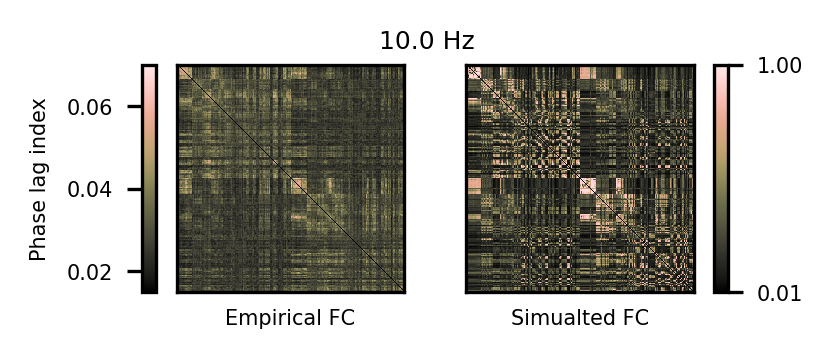

In [2007]:
### Plot PLV-FC ###
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

# create figure
fig, ax = plt.subplots(1, 2, figsize=(5.8*cm, 2.5*cm), dpi=300)

plt.suptitle('10.0 Hz', y = 1.0)

im = ax[0].imshow(FC_emp_alpha_avg, cmap=cmap_fc, aspect=1, vmin=np.round(FC_emp_alpha_avg[FC_emp_alpha_avg!=0].min(), decimals=2), vmax=np.round(FC_emp_alpha_avg.max(), decimals=2), interpolation='none')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel('Empirical FC', size=5)

cbar_ax = fig.add_axes([0.085, 0.11, 0.02, 0.77])
cbar = fig.colorbar(im, ax=ax[0], cax=cbar_ax, pad=0.02)
cbar.set_label('Phase locking value')
cbar.set_ticks(ticks=[np.round(FC_emp_alpha_avg[FC_emp_alpha_avg!=0].min(), decimals=2), np.round(FC_emp_alpha_avg.max(), decimals=2)])
cbar.ax.yaxis.tick_left()
cbar.ax.yaxis.set_label_position('left')

im = ax[1].imshow(FC_pli_sim_alpha_avg, cmap=cmap_fc, aspect=1, vmin=np.round(FC_pli_sim_alpha_avg[FC_pli_sim_alpha_avg!=0].min(), decimals=2), vmax=np.round(FC_pli_sim_alpha_avg.max(), decimals=2), interpolation='none')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel('Simualted FC', size=5)

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
cbar = fig.colorbar(im, ax=ax[1], cax=cbar_ax, pad=0.02)
cbar.set_ticks(ticks=[np.round(FC_sim_alpha_avg[FC_sim_alpha_avg!=0].min(), decimals=2), np.round(FC_sim_alpha_avg.max(), decimals=2)])

#plt.savefig(os.path.join(figure_path, '40_plv-fc_emp-sim_alpha.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, '40_plv-fc_emp-sim_alpha.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [ ]:
### Plot PLI-FC ###
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

# create figure
fig, ax = plt.subplots(1, 2, figsize=(5.8*cm, 2.5*cm), dpi=300)

plt.suptitle('10.0 Hz', y = 1.0)


im = ax[0].imshow(FC_pli_emp_alpha_avg, cmap=cmap_fc, aspect=1, vmin=FC_pli_emp_alpha_avg[FC_emp_alpha_avg!=0].min(), vmax=np.round(FC_pli_emp_alpha_avg.max(), decimals=2), interpolation='none')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel('Empirical FC', size=5)

cbar_ax = fig.add_axes([0.085, 0.11, 0.02, 0.77])
cbar = fig.colorbar(im, ax=ax[0], cax=cbar_ax, pad=0.02)
cbar.set_label('Phase lag index')
cbar.ax.yaxis.tick_left()
cbar.ax.yaxis.set_label_position('left')

im = ax[1].imshow(FC_pli_sim_alpha_avg, cmap=cmap_fc, aspect=1, vmin=np.round(FC_pli_sim_alpha_avg[FC_pli_sim_alpha_avg!=0].min(), decimals=2), vmax=np.round(FC_pli_sim_alpha_avg.max(), decimals=2), interpolation='none')
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_xlabel('Simualted FC', size=5)

cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
cbar = fig.colorbar(im, ax=ax, cax=cbar_ax, pad=0.02)
cbar.set_ticks(ticks=[np.round(FC_pli_sim_alpha_avg[FC_pli_sim_alpha_avg!=0].min(), decimals=2), np.round(FC_pli_sim_alpha_avg.max(), decimals=2)])

#plt.savefig(os.path.join(figure_path, '40_pli-fc_emp-sim_alpha.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, '40_pli-fc_emp-sim_alpha.svg'), dpi=300, transparent=False, bbox_inches='tight')

### Empirical - simulated Functional connectivity correlation

In [130]:
experiment_id = '48_rank2'
metric = 'pli'

if experiment_id == '48' or experiment_id == '48_rank2':
    intrinsic_freqs = intrinsic_frequency[1:3]
else :
    intrinsic_freqs = intrinsic_frequency[1:]

In [131]:
FC_corr = []
for frequency_idx, freq in enumerate(intrinsic_freqs, start=1):
    for coupling_strength_idx, coupling in enumerate(coupling_strength):
        for conduction_speed_idx, speed in enumerate(conduction_speed):
            FC_rho = np.load(os.path.join(data_path, f"{experiment_id}_analysis_fc_corr", f"{experiment_id}_fc_{metric}_corr_all_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))
            FC_corr.append([freq, coupling*1000, speed, FC_rho])

In [132]:
# guided waves
# ------------
# build dataframe
FC_stats = pd.DataFrame(FC_corr, columns=['frequency', 
                                          'coupling strength', 
                                          'conduction speed', 
                                          'FC_corr'
                                         ]
                       )


# Aggregate metric
# ---------------
fc_freq = []
for i, fq in enumerate(intrinsic_freqs):  
    # FC correlation per frequency
    fc_freq.append(FC_stats.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                  columns='conduction speed', 
                                                                  values='FC_corr',
                                                                  dropna=False)
                  )

Text(0.5, 0.98, ' ')

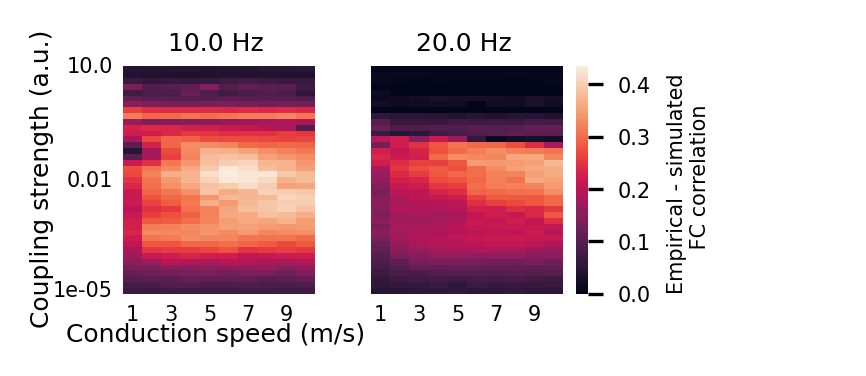

In [133]:
# Assemble figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(6.3*cm, 2.5*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency[1:]))

for i, fq in enumerate(intrinsic_freqs):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1)
    
    p = sns.heatmap(fc_freq[i].astype(float), cmap=cmap, vmin=0., vmax=FC_stats.FC_corr.max(), 
                    cbar = True if i==len(intrinsic_freqs)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.11, .05, .77]) if i==len(intrinsic_freqs)-1 else None, 
                    cbar_kws={'label': 'Empirical - simulated \n FC correlation'} if i==len(intrinsic_freqs)-1 else None, 
                    ax=ax)
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    
    if i==0:
        subfigs[i].text(0.5, -0.05, 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.25, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'{experiment_id}_fc_pli.svg'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_fc_pli.png'), dpi=300, transparent=True, bbox_inches='tight')

In [134]:
# find maximum of empirical-simulated FC correlation
FC_max_coords = []
FC_max_corr = []


for i, freq in enumerate(intrinsic_freqs):
    FC_max_coords.append(np.unravel_index(np.argmax(fc_freq[i].to_numpy()), fc_freq[i].to_numpy().shape))
    FC_max_corr.append(np.max(fc_freq[i].to_numpy()))

FC_max_coords, FC_max_corr

([(20, 5), (22, 9)], [0.4340773186003709, 0.3766162958698299])

In [93]:
# instrength - effective frequency correlation at max FC
for i, freq in enumerate(intrinsic_frequency[1:]):
    # average across hemispheres
    freq_corr = np.nanmean([frequency_instrength_corr_freq_lh[i+1], frequency_instrength_corr_freq_rh[i+1]], axis=0)
    print(freq_corr[FC_max_coords[i]])

-0.7090076056304224
-0.7609736406945629


IndexError: list index out of range

In [50]:
# instrength - potential correlation at max FC
for i, freq in enumerate(intrinsic_frequency[1:]):
    # average across hemispheres
    waves_corr = np.nanmean([guided_waves_corr_lh[i+1], guided_waves_corr_rh[i+1]], axis=0)
    print(waves_corr[FC_max_coords[i]])

-0.6576554338299611
-0.6513029694258199
-0.6535367935695543


# Effective frequency exploration

### Resting-state MEG effective frequency gradients

In [9]:
# load MEG subject IDs
subject_ids = np.genfromtxt(os.path.join(data_path, f"hcp_meg/subjects.txt"), dtype=str)

In [2221]:
# Compute effective frequency
sfreq = 100.0  # Hz

avg_effective_frequency = []
for ib, band in enumerate(['alpha', 'beta']):
    effective_frequency_subject_avg = []
    for isub, subject_id in enumerate(subject_ids):
        print(f"\rSubject {isub}, {band} band", end="")

        sources = np.load(os.path.join(data_path, f"hcp_meg/hcp-subjects_lcmv/{subject_id}/sources_lcmv_{subject_id}_{band}.npy"))

        analytic_signal = hilbert(sources, axis=1)
        phase = np.angle(analytic_signal)

        effective_frequency = compute_instantaneous_frequency(np.exp(1j*phase), 1/sfreq)
        effective_frequency_subject_avg.append(np.median(effective_frequency,axis=1))

    avg_effective_frequency.append(np.mean(effective_frequency_subject_avg, axis=0))
    
## Save empirical effective frequencies
#np.load(os.path.join(data_path, 'hcp_meg/avg_effective_frequency_alpha_IF.npy'), avg_effective_frequency[0])
#np.load(os.path.join(data_path, 'hcp_meg/avg_effective_frequency_beta_IF.npy'), avg_effective_frequency[1])

Subject 1, alpha band

KeyboardInterrupt: 

In [7]:
# Load empirical effective frequencies
alpha_ef = np.load(os.path.join(data_path, 'hcp_meg/avg_effective_frequency_alpha_IF.npy'))
beta_ef = np.load(os.path.join(data_path, 'hcp_meg/avg_effective_frequency_beta_IF.npy'))

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


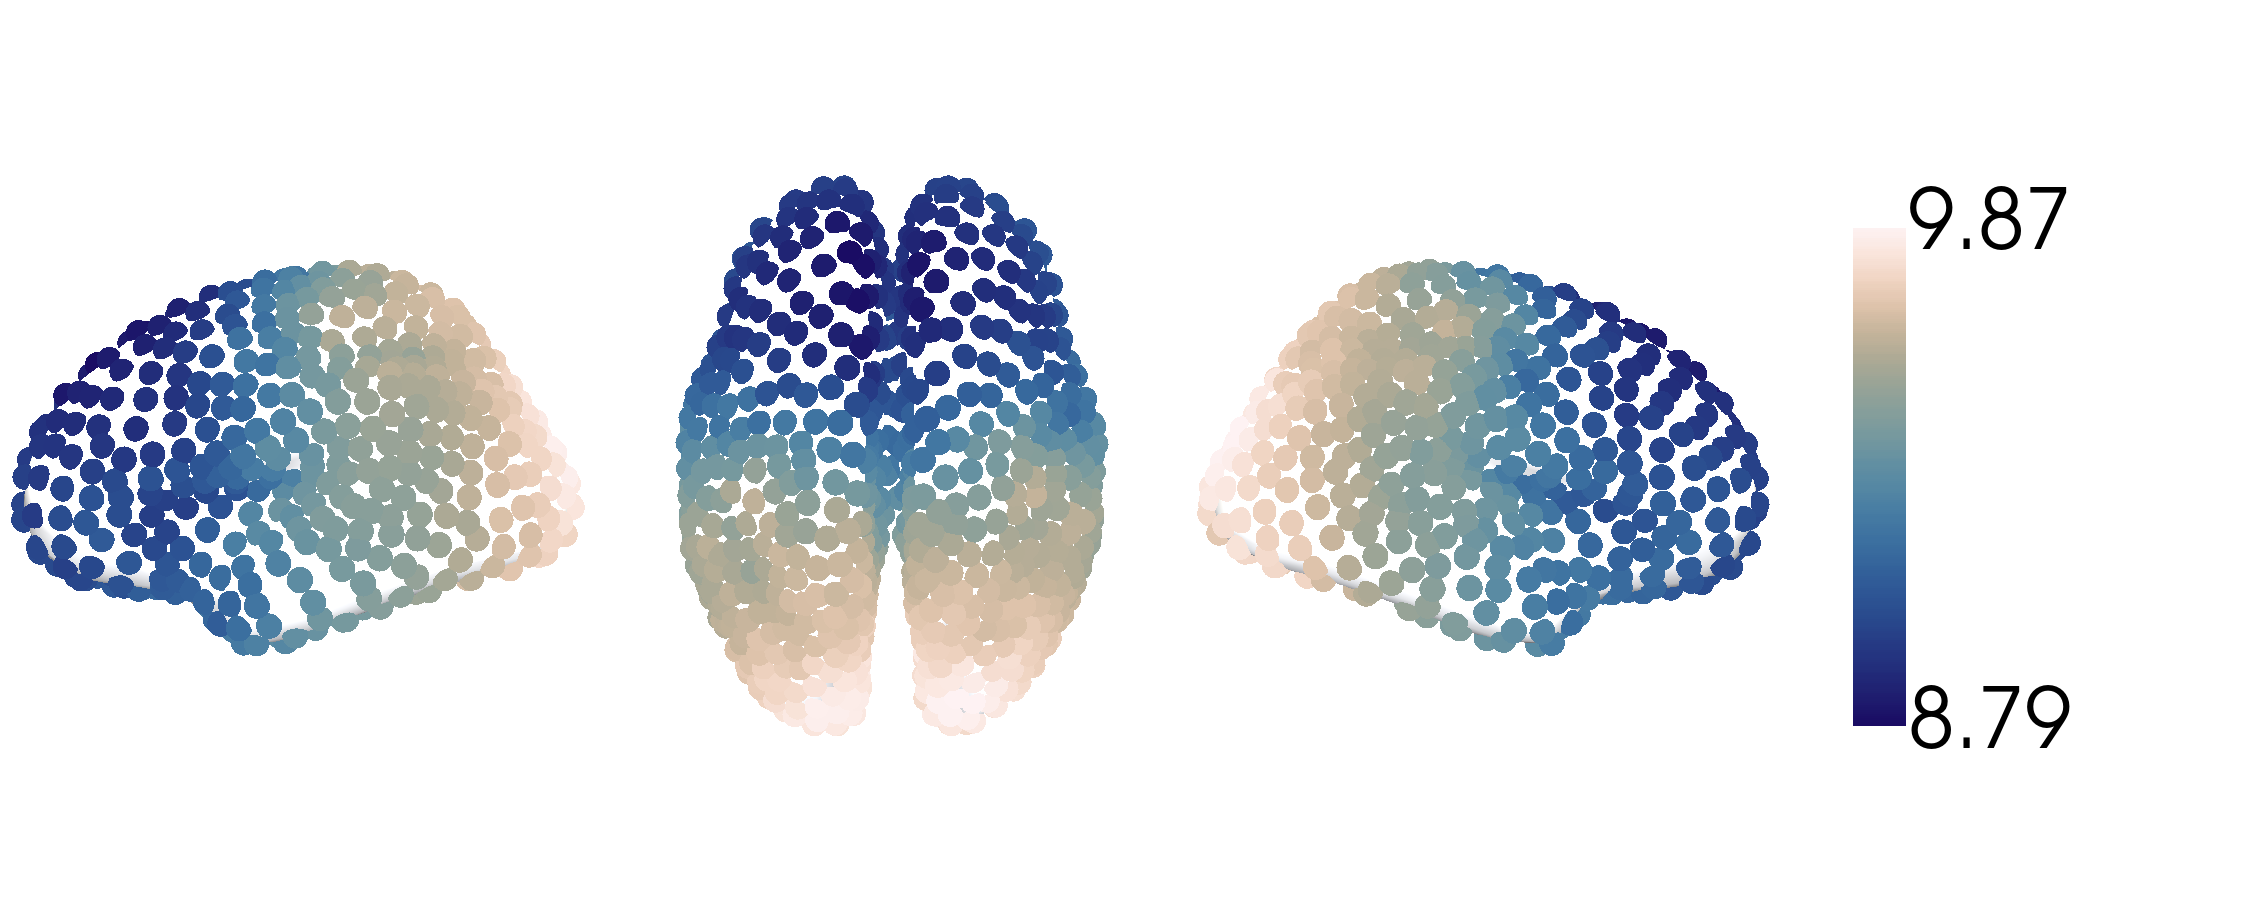

In [20]:
# Plot empirical alpha effective frequency
plot_brain_data(v, f, alpha_ef, filename=None, cmap=cmap_fq, clim=None)
#plot_brain_data(v, f, alpha_ef, filename=os.path.join(figure_path, f'{experiment_id}_alpha_emp_effective_frequency.png'), cmap=cmap_fq)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


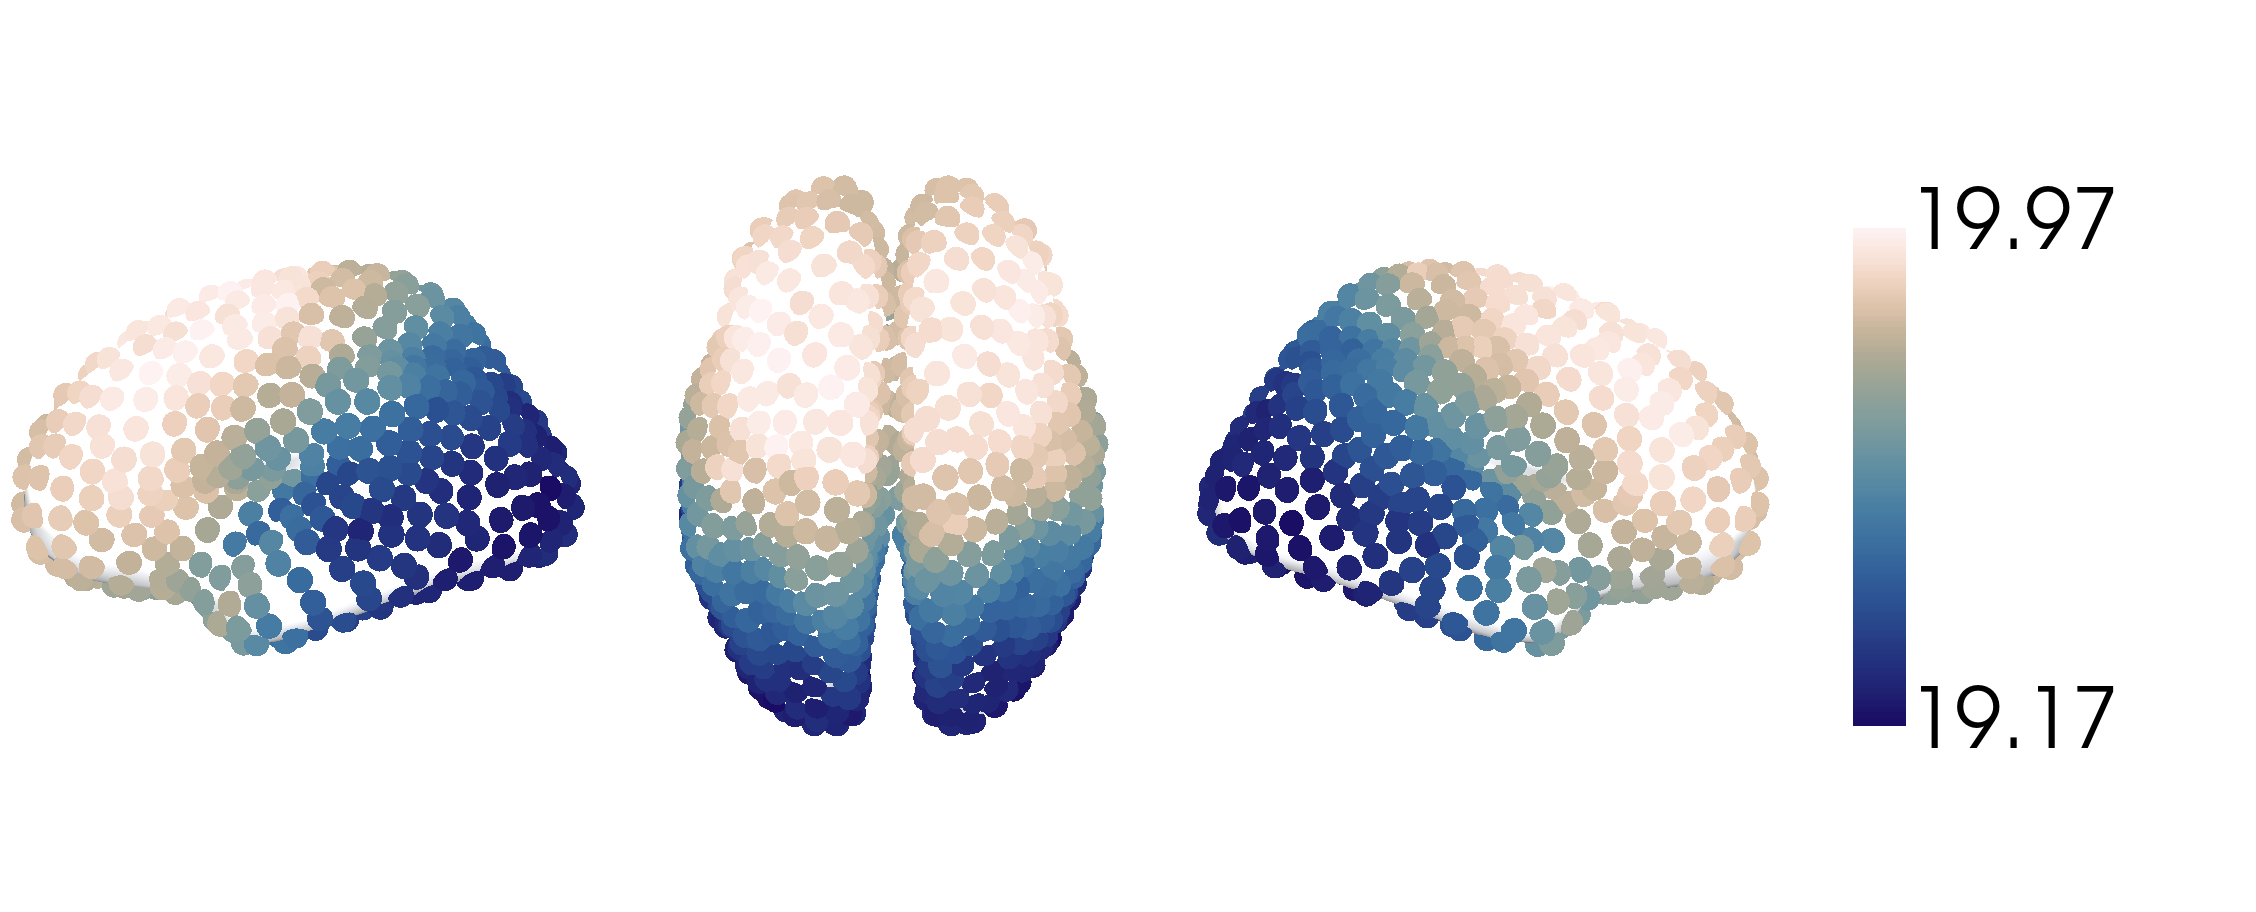

In [19]:
# Plot empirical beta effective frequency
plot_brain_data(v, f, beta_ef, filename=None, cmap=cmap_fq, clim=None)
#plot_brain_data(v, f, beta_ef, filename=os.path.join(figure_path, f'{experiment_id}_beta_emp_effective_frequency.png'), cmap=cmap_fq)

### Effective frequency concordance exploration

In [135]:
# Aggregate results
ef_ccc = []
for frequency_idx, freq in enumerate(intrinsic_freqs, start=1):
    for coupling_strength_idx, coupling in enumerate(coupling_strength):
        for conduction_speed_idx, speed in enumerate(conduction_speed):
            ef_con = np.load(os.path.join(data_path, f"{experiment_id}_analysis_ef_ccc", f"{experiment_id}_ef_ccc_all_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy"))            
            ef_ccc.append([freq, coupling*1000, speed, ef_con])

In [136]:
# guided waves
# ------------
# build dataframe
ef_ccc_stats = pd.DataFrame(ef_ccc, columns=['frequency', 
                                          'coupling strength', 
                                          'conduction speed', 
                                          'ef_ccc'
                                         ]
                       )


# Aggregate metric
# ---------------
ef_ccc_freq = []
for i, fq in enumerate(intrinsic_freqs):  
    # FC correlation per frequency
    ef_ccc_freq.append(ef_ccc_stats.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                  columns='conduction speed', 
                                                                  values='ef_ccc',
                                                                  dropna=False)
                  )

Text(0.5, 0.98, ' ')

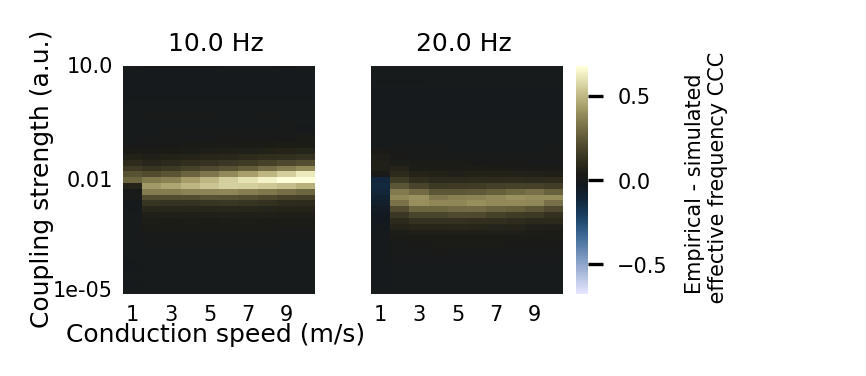

In [137]:
# Assemble figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

cmap = cmap_corr
vabs = np.max(np.abs([ef_ccc_stats.ef_ccc.min(), ef_ccc_stats.ef_ccc.max()]))

# create figure
fig = plt.figure(figsize=(6.3*cm, 2.5*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency[1:]))

for i, fq in enumerate(intrinsic_frequency[1:3]):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1)
    
    p = sns.heatmap(ef_ccc_freq[i].astype(float), cmap=cmap, vmin=-vabs, vmax=vabs,
                    cbar = True if i==len(intrinsic_frequency[1:3])-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.11, .05, .77]) if i==len(intrinsic_frequency[1:3])-1 else None, 
                    cbar_kws={'label': 'Empirical - simulated \n effective frequency CCC'} if i==len(intrinsic_frequency[1:3])-1 else None, 
                    ax=ax)
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    
    if i==0:
        subfigs[i].text(0.5, -0.05, 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.25, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'{experiment_id}_ef_ccc.svg'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_ef_ccc.png'), dpi=300, transparent=True, bbox_inches='tight')

In [138]:
# find maximum of empirical-simulated CCC
ef_max_coords = []
ef_max_ccc = []

for i, freq in enumerate(intrinsic_frequency[1:3]):
    ef_max_coords.append(np.unravel_index(np.argmax(ef_ccc_freq[i].to_numpy()), ef_ccc_freq[i].to_numpy().shape))
    ef_max_ccc.append(np.max(ef_ccc_freq[i].to_numpy()))
    
ef_max_coords, ef_max_ccc

([(19, 9), (16, 2)], [0.6741004316054823, 0.4021776527112208])

# Functional connectivity + Effective frequency concordance exploration

In [139]:
# Compute FC + EF CCC
multi_fit = []
for i, fq in enumerate(intrinsic_frequency[1:3]):
    multi_fit.append(ef_ccc_freq[i].values + fc_freq[i].values)

Text(0.5, 0.98, ' ')

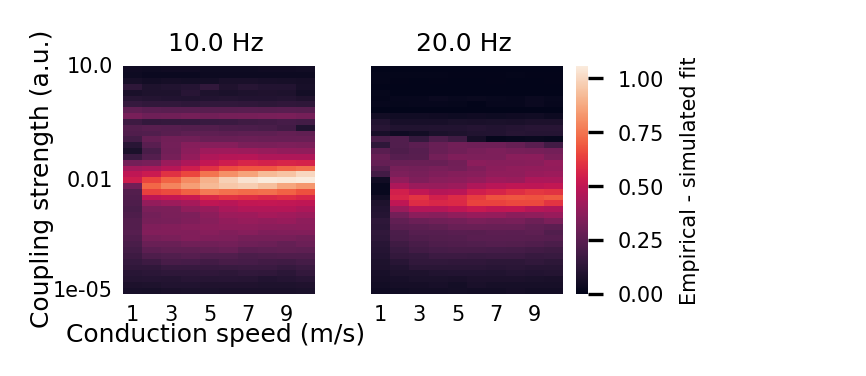

In [140]:
# Assemble figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({
    "figure.facecolor":  (1.0, 0.0, 0.0, 0),  # red   with alpha = 30%
    "axes.facecolor":    (0.0, 1.0, 0.0, 0),  # green with alpha = 50%
    "savefig.facecolor": (0.0, 0.0, 1.0, 0),  # blue  with alpha = 20%
})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(6.3*cm, 2.5*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency[1:]))

for i, fq in enumerate(intrinsic_frequency[1:3]):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1)
    
    p = sns.heatmap(multi_fit[i].astype(float), cmap=cmap, vmin=0., vmax=np.max(multi_fit), 
                    cbar = True if i==len(intrinsic_frequency[1:])-2 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.11, .05, .77]) if i==len(intrinsic_frequency[1:])-2 else None, 
                    cbar_kws={'label': 'Empirical - simulated fit'} if i==len(intrinsic_frequency[1:])-2 else None, 
                    ax=ax)
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    
    if i==0:
        subfigs[i].text(0.5, -0.05, 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.25, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'{experiment_id}_multi_fit.svg'), dpi=300, transparent=True, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'{experiment_id}_multi_fit.png'), dpi=300, transparent=True, bbox_inches='tight')

In [141]:
# find best fit
multi_fit_max_coords = []
multi_fit_max = []


for i, freq in enumerate(intrinsic_frequency[1:3]):
    multi_fit_max_coords.append(np.unravel_index(np.argmax(multi_fit[i]), multi_fit[i].shape))
    multi_fit_max.append(np.max(multi_fit[i].astype(float)))
    
multi_fit_max_coords, multi_fit_max

([(19, 7), (16, 9)], [1.0546965920008335, 0.6886278792151984])

# Summary of peak fits


**Original cortical network model**
|               | alpha | beta | gamma | 
|---------------|-------|------|-------| 
|PLV-FC coupling|19     |20    |22     | 
|PLV-FC speed   |2      |5     |9      |
|PLI-FC coupling|16     |19    |23     | 
|PLI-FC speed   |8      |7     |9      |
|EF CCC coupling|19     |16    |       | 
|EF CCC speed   |9      |2     |       |
|EF+FC  coupling|19     |16    |       | 
|EF+FC  speed   |7      |9     |       |

**Alpha and beta subnetwork models (rank-5)**
|               | alpha | beta |
|---------------|-------|------|
|PLV-FC coupling|24     |26    |
|PLV-FC speed   |2      |5     |
|PLI-FC coupling|16     |23    |
|PLI-FC speed   |9      |9     |
|EF CCC coupling|20     |20    |
|EF CCC speed   |9      |1     |
|EF+FC  coupling|20     |19    |
|EF+FC  speed   |9      |8     |

**Alpha and beta subnetwork models (rank-2)**
|               | alpha | beta |
|---------------|-------|------|
|PLV-FC coupling|21     |23    |
|PLV-FC speed   |3      |4     |
|PLI-FC coupling|20     |22    |
|PLI-FC speed   |5      |9     |
|EF CCC coupling|19     |16    |
|EF CCC speed   |9      |2     |
|EF+FC  coupling|19     |16    |
|EF+FC  speed   |7      |9     |

# Visualization

### Create example videos

In [144]:
experiment_id = '48_rank2'
sim = 0
fi = 2
gi = 16
vi = 9

print(f"Intrinsic frequency = {intrinsic_frequency[fi]} Hz\n"
      f"Coupling strength = {coupling_strength[gi]}\n"
      f"Conduction speed = {conduction_speed[vi]} m/s"
     )

phase = np.load(os.path.join(data_path, f"{experiment_id}_simulations/{experiment_id}_simulation_{sim}_{fi}_{gi}_{vi}.npy")).T

# downsampling of timesteps
phase = phase[:, np.arange(initial_transient, phase.shape[1], integration_step_size_downsampled).astype(int)]
activity = np.real(np.exp(1j*phase))

Intrinsic frequency = 20.0 Hz
Coupling strength = 3.359818286283781e-06
Conduction speed = 10.0 m/s


In [145]:
# create movie
filename = os.path.join(data_path, f"40_results/figures/{experiment_id}_sim_{sim}_{fi}_{gi}_{vi}_example.mp4")

clim = np.percentile(activity.flatten(), [5, 95])
time = np.linspace(0, simulation_duration, number_of_timesteps_downsampled+1)

make_brain_data_movie(v, f, activity, time, 5000, 6000, filename, clim=clim, cmap=cmap_waves)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")
/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/dataset.py:1941: PyVistaDeprecationWarning: Use of `DataSet.overwrite` is deprecated. Use `DataSet.copy_from` instead.
  warnings.warn(


### Plot effective frequency and flow potential topographies

The examples that we used in figure 5 of the paper were: 0,16,0 - 1,20,0 - 2,22,9 - 3,25,8 (frequency_idx, coupling_strength_idx, speed_idx).


In [400]:
# Compute flow potential and effective frequency
# ----------------------------------------------
experiment_id = '48_rank2'
frequency_idx = 2
coupling_strength_idx = 16
conduction_speed_idx = 9


instantaneous_frequency_lh_sum = np.zeros(number_of_regions_per_hemi)
instantaneous_frequency_rh_sum = np.zeros(number_of_regions_per_hemi)

number_of_simulations = len(simulation_ids)

U = []

for simulation_id in simulation_ids:
    # Frequency distribution
    # ----------------------
    # load phase
    phase = np.load(os.path.join(data_path, f'{experiment_id}_simulations', f'{experiment_id}_simulation_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy')).T
    phase = phase[:, np.arange(initial_transient, phase.shape[1], integration_step_size).astype(int)]  # downsampling    
    ce_phase = np.exp(1j*phase)  # complex exponential phase

    
    frequency_tmp = compute_instantaneous_frequency(ce_phase, integration_step_size*1e-3)
    
    instantaneous_frequency_lh_sum += np.nanmedian(frequency_tmp[:number_of_regions_per_hemi], axis=1)
    instantaneous_frequency_rh_sum += np.nanmedian(frequency_tmp[number_of_regions_per_hemi:], axis=1)
    
    
    # Compute Spatial Gradients
    # -------------------------
    # remove initial transient and downsample timesteps 
    phase_lh = phase[:number_of_regions_per_hemi, np.arange(0, phase.shape[1], integration_step_size_downsampled).astype(int)]
    phase_rh = phase[number_of_regions_per_hemi:, np.arange(0, phase.shape[1], integration_step_size_downsampled).astype(int)]
    
    # pre-compute gradient operator
    gradient_operator_lh = igl.grad(v_lh, f_lh)
    gradient_operator_rh = igl.grad(v_rh, f_rh)

    # pre-compute barycenters
    bc_coords_lh = compute_barycentric_coords(v_lh, f_lh)
    bc_coords_rh = compute_barycentric_coords(v_rh, f_rh)
    
    # compute spatial gradient
    phase_grad_lh = compute_phase_gradient(phase_lh, f_lh, bc_coords_lh, gradient_operator_lh)
    phase_grad_rh = compute_phase_gradient(phase_rh, f_rh, bc_coords_rh, gradient_operator_rh)

    # compute spatial gradient magnitude    
    phase_grad_norm_lh = (phase_grad_lh / np.linalg.norm(phase_grad_lh, axis=0)).T 
    phase_grad_norm_rh = (phase_grad_rh / np.linalg.norm(phase_grad_rh, axis=0)).T 


    # Compute Helmholtz-Hodge Decomposition
    # -------------------------------------
    U_lh = compute_helmholtz_hodge_decomposition(-phase_grad_norm_lh, v_lh, f_lh)  # negative phase gradient to get flow direction
    U_rh = compute_helmholtz_hodge_decomposition(-phase_grad_norm_rh, v_rh, f_rh)  # negative phase gradient to get flow direction

    U.append(np.concatenate([U_lh, U_rh]))


# Compute instantenous frequency mean
instantaneous_frequency_lh_mean = instantaneous_frequency_lh_sum / number_of_simulations
instantaneous_frequency_rh_mean = instantaneous_frequency_rh_sum / number_of_simulations

effective_frequency = np.concatenate([instantaneous_frequency_lh_mean, instantaneous_frequency_rh_mean])

# Compute average potential
U_avg = np.mean(np.mean(U, axis=-1), axis=0)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


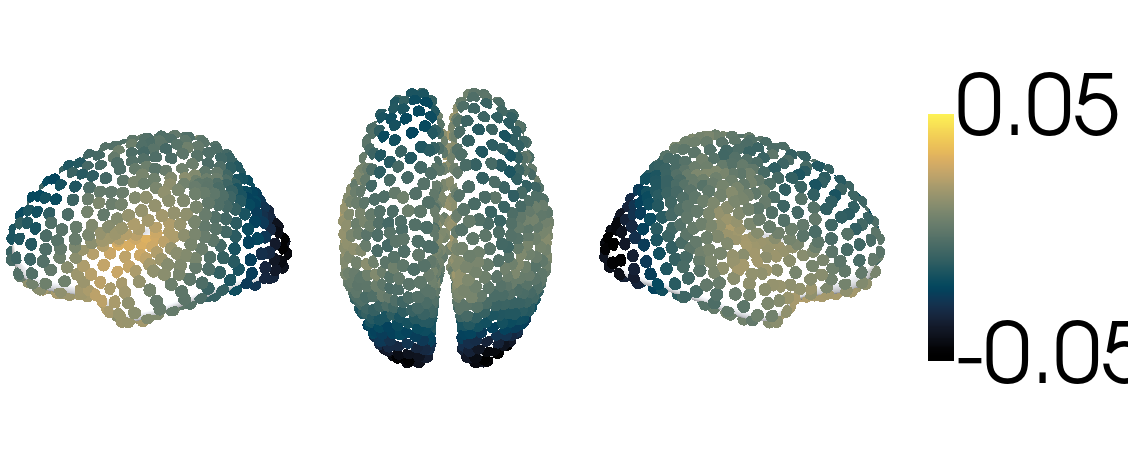

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [401]:
# Plot average potential
# ---------------------
filename = os.path.join(figure_path, f'{experiment_id}_flow_potential_all_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.png')

cabs = np.max(np.abs(U_avg))
clims = [-cabs, cabs]

plot_brain_data(v, f, U_avg, cmap=cmap_potential, clim=clims, window_size=(int(2256/2), int(912/2)))
plot_brain_data(v, f, U_avg, filename=filename, cmap=cmap_potential, clim=clims)

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


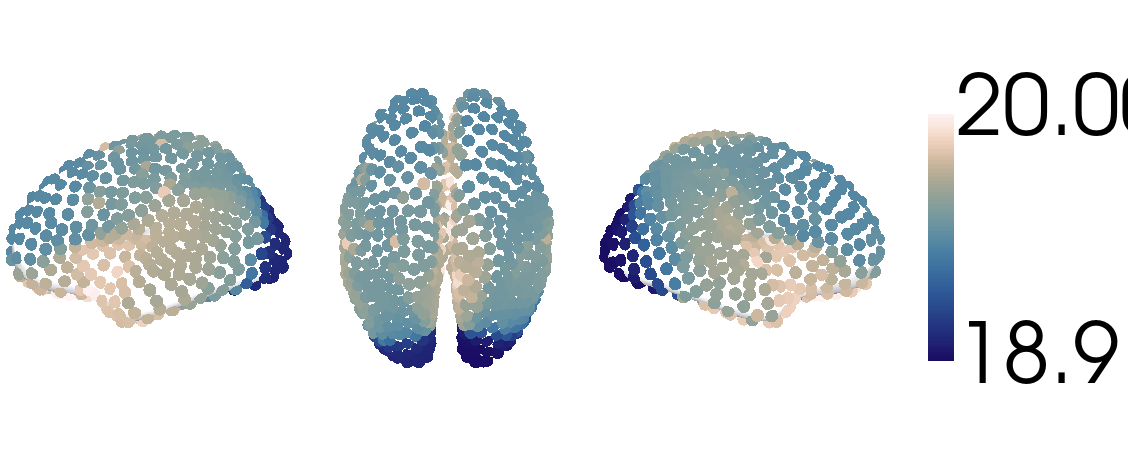

/Users/dk/mambaforge/envs/waves/lib/python3.11/site-packages/pyvista/core/filters/data_set.py:2296: UserWarning: No vector-like data to use for orient. orient will be set to False.
  warnings.warn("No vector-like data to use for orient. orient will be set to False.")


In [402]:
# Plot average effective frequency
# --------------------------------
#clims = np.percentile(effective_frequency.flatten(), [5, 95])
filename = os.path.join(figure_path, f'{experiment_id}_effective_frequency_all_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.png')

plot_brain_data(v, f, effective_frequency, cmap=cmap_fq, clim=None, window_size=(int(2256/2), int(912/2)))
plot_brain_data(v, f, effective_frequency, filename=filename, cmap=cmap_fq, clim=None)

# Supplemental analyses

### Wave speeds

In [197]:
wave_speed = []
for simulation_id in simulation_ids:
    for frequency_idx, freq in enumerate(intrinsic_frequency):
        for coupling_strength_idx, coupling in enumerate(coupling_strength):
            for conduction_speed_idx, speed in enumerate(conduction_speed):
                try:
                    wave_speed_lh = np.median(np.load(os.path.join(data_path, "40_analysis_wave_speed", f"40_wave_speed_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                    wave_speed_rh = np.median(np.load(os.path.join(data_path, "40_analysis_wave_speed", f"40_wave_speed_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                except:
                    # set wave speed to NaN if there are no waves
                    wave_speed_lh = np.nan
                    wave_speed_rh = np.nan
                
                wave_speed.append([simulation_id, freq, coupling*1000, speed,
                                              wave_speed_lh,
                                              wave_speed_rh
                                             ])

In [198]:
# guided waves
# ------------
# build dataframe
wave_speed_stats = pd.DataFrame(wave_speed, columns=['simulation id', 'frequency', 'coupling strength', 'conduction speed', 
                                                             'wave speed (left)',
                                                             'wave speed (right)'
                                                            ])

# set wave speed to NaN where too few waves were observed
wave_speed_stats.loc[wave_stats_proportions['proportions threshold (left)'], 'wave speed (left)'] = np.nan
wave_speed_stats.loc[wave_stats_proportions['proportions threshold (right)'], 'wave speed (right)'] = np.nan

# average across simulations
wave_speed_stats_avg = wave_speed_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()


# Aggregate metrics
# -----------------
wave_speed_freq_lh = []
wave_speed_freq_rh = []

for i, fq in enumerate(intrinsic_frequency):  
    # wave speeds per per frequency
    wave_speed_freq_lh.append(wave_speed_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                         columns='conduction speed', 
                                                                                         values='wave speed (left)', 
                                                                                         dropna=False)
                             )
    wave_speed_freq_rh.append(wave_speed_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                         columns='conduction speed', 
                                                                                         values='wave speed (right)',
                                                                                         dropna=False)
                             )

Text(0.5, 0.98, ' ')

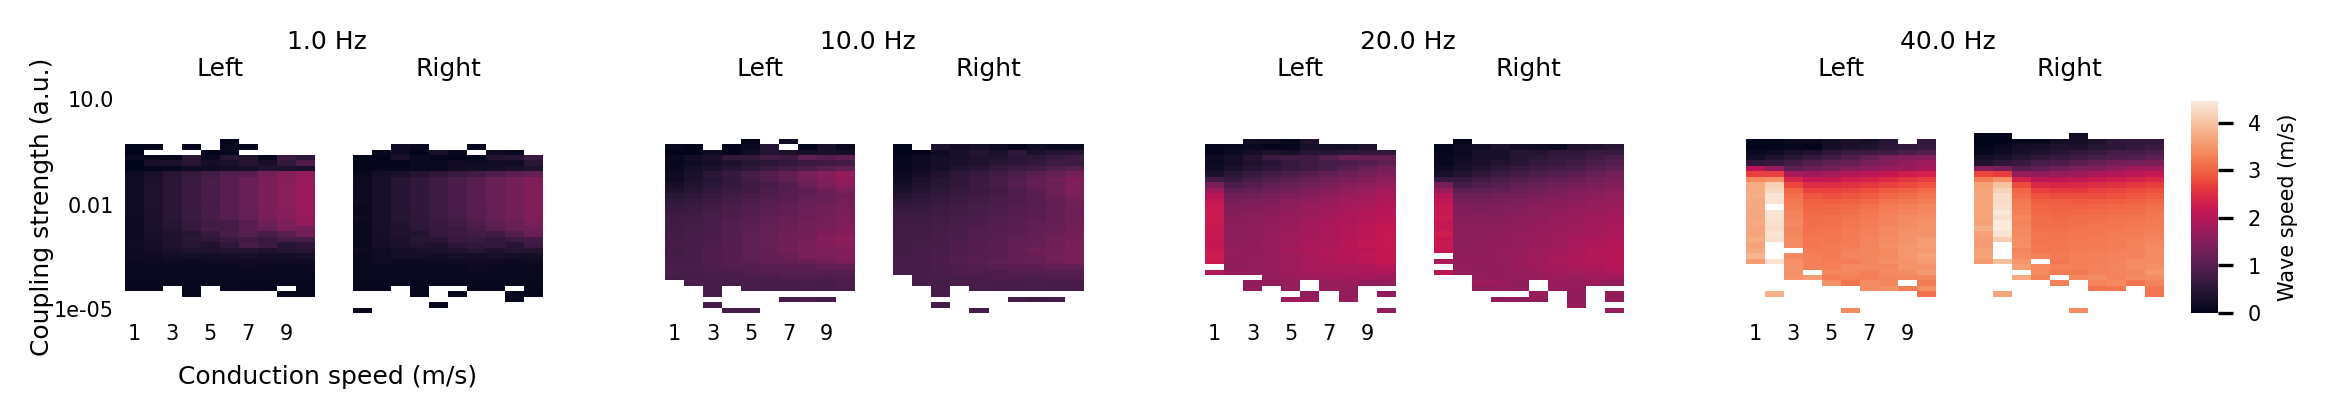

In [199]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(18.3*cm, 3.0*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency))


vmax=np.max([np.nanmax(wave_speed_freq_lh), np.nanmax(wave_speed_freq_rh)])
for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)

    ax = subfigs[i].subplots(1,2)
    subfigs[i].subplots_adjust(top=0.8, bottom=0.2)
    
    p = sns.heatmap(wave_speed_freq_lh[i], vmin=0, vmax=vmax, cmap=cmap, cbar=None, ax=ax[0])
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.set_title('Left', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(wave_speed_freq_rh[i], vmin=0, vmax=vmax, cmap=cmap,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.2, .05, .6]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Wave speed (m/s)'} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[1]
                   )
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=[])
    p.set_title('Right', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    
    if i==0:
        subfigs[i].text(0.5, 0., 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.05, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'40_wave_speed.svg'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'40_wave_speed.png'), dpi=300, transparent=False, bbox_inches='tight')

### Effective frequency

In [25]:
frequency = []
for simulation_id in simulation_ids:
    for frequency_idx, freq in enumerate(intrinsic_frequency):
        for coupling_strength_idx, coupling in enumerate(coupling_strength):
            for conduction_speed_idx, speed in enumerate(conduction_speed):
                try:
                    frequency_lh = np.mean(np.load(os.path.join(data_path, "40_analysis_frequency_instrength_corr", f"40_instantaneous_frequency_median_lh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                    frequency_rh = np.mean(np.load(os.path.join(data_path, "40_analysis_frequency_instrength_corr", f"40_instantaneous_frequency_median_rh_{simulation_id}_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
                except:
                    # set frequency to NaN where no waves were found
                    frequency_lh = np.nan
                    frequency_rh = np.nan
                frequency.append([simulation_id, freq, coupling*1000, speed,
                                              frequency_lh,
                                              frequency_rh
                                             ])

In [26]:
# guided waves
# ------------
# build dataframe
frequency_stats = pd.DataFrame(frequency, columns=['simulation id', 'frequency', 'coupling strength', 'conduction speed', 
                                                             'frequency (left)',
                                                             'frequency (right)'
                                                            ])

# set effective frequency to NaN where too few waves were observed
frequency_stats.loc[wave_stats_proportions['proportions threshold (left)'], 'frequency (left)'] = np.nan
frequency_stats.loc[wave_stats_proportions['proportions threshold (right)'], 'frequency (right)'] = np.nan

# average across simulations
ferquency_stats_avg = frequency_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()


# Aggregate metrics
# -----------------
frequency_freq_lh = []
frequency_freq_rh = []

for i, fq in enumerate(intrinsic_frequency):  
    # guided waves correlation per frequency
    frequency_freq_lh.append(ferquency_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                       columns='conduction speed', 
                                                                                       values='frequency (left)',
                                                                                       dropna=False)
                            )
    frequency_freq_rh.append(ferquency_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                       columns='conduction speed', 
                                                                                       values='frequency (right)',
                                                                                       dropna=False)
                            )

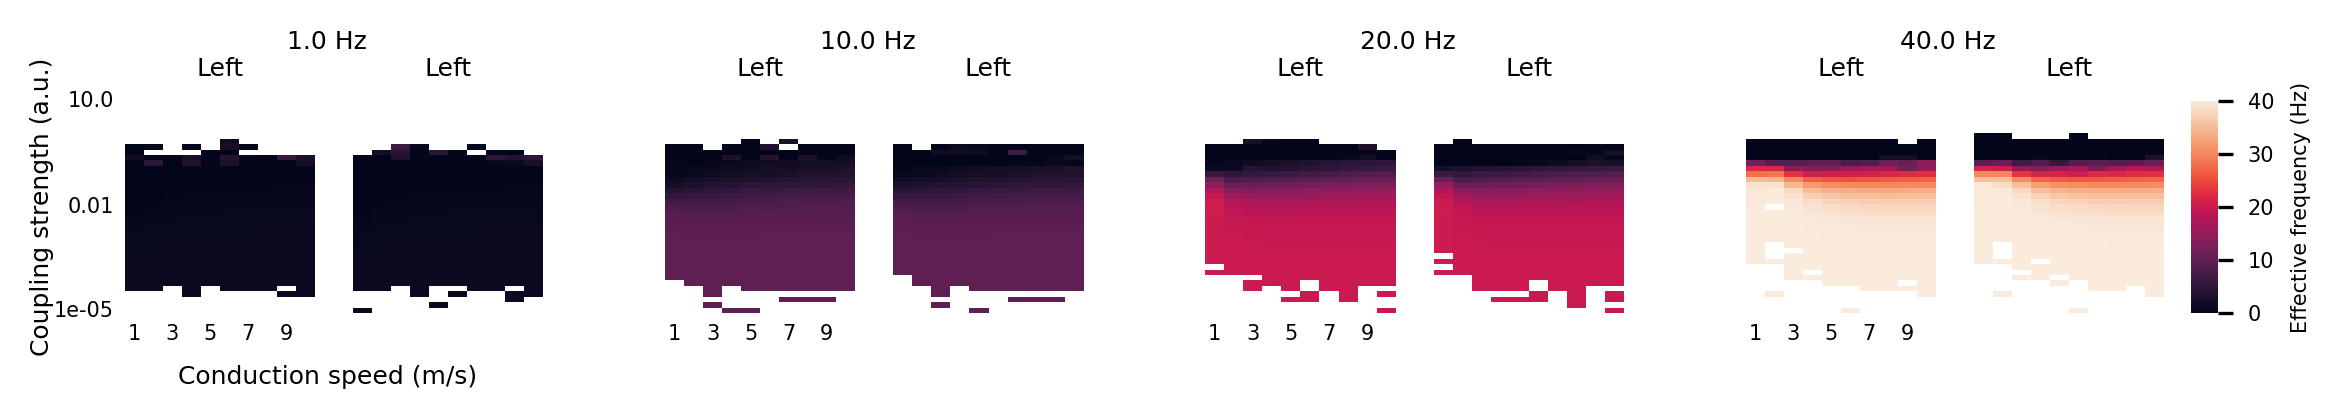

In [28]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(18.3*cm, 3*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency))


for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1,2)
    subfigs[i].subplots_adjust(top=0.8, bottom=0.2)

    p = sns.heatmap(frequency_freq_lh[i], vmin=0, vmax=40, cmap=cmap, cbar=None, ax=ax[0])
    p.set_yticks(np.array([0.5, 19.5, 39]))
    p.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set(xlabel=None, xticklabels=conduction_speed.astype(int)[::2])
    p.set_title('Left', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    p = sns.heatmap(frequency_freq_rh[i], vmin=0, vmax=40, cmap=cmap,
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.2, .05, .6]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Effective frequency (Hz)'} if i==len(intrinsic_frequency)-1 else None, 
                    ax=ax[1])
    p.set(xlabel=None, ylabel=None, yticklabels=[], xticklabels=[])
    p.set_title('Left', y=1)
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    if i==0:
        subfigs[i].text(0.5, 0., 'Conduction speed (m/s)', ha='center', fontsize='large')
        subfigs[i].text(-0.05, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize='large')

fig.suptitle(' ')

#plt.savefig(os.path.join(figure_path, f'40_effective_frequency.svg'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, f'40_effective_frequency.png'), dpi=300, transparent=False, bbox_inches='tight')

# Metastability

### Inter-hemispheric Cross-correlation (Roberts et al., 2019)

In [11]:
# Aggregate dwell times
dwell_times = []
for frequency_idx, freq in enumerate(intrinsic_frequency):
    for coupling_strength_idx, coupling in enumerate(coupling_strength):
        for conduction_speed_idx, speed in enumerate(conduction_speed):
            dwell_times_tmp = np.median(np.load(os.path.join(data_path, "40_analysis_dwell_times", f"40_dwell_times_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
            dwell_times.append([freq, coupling*1000, speed, dwell_times_tmp])

/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dk/miniforge3/envs/tvb-waves/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
# build dataframe
dwell_times_stats = pd.DataFrame(dwell_times, columns=['frequency', 'coupling strength', 'conduction speed', 'dwell times'])

# average across simulations
dwell_times_stats_avg = dwell_times_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()


# Aggregate metrics
# -----------------
dwell_times_freq = []

for i, fq in enumerate(intrinsic_frequency):  
    # guided waves correlation per frequency
    dwell_times_freq.append(dwell_times_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                       columns='conduction speed', 
                                                                                       values='dwell times',
                                                                                       dropna=False)
                           )

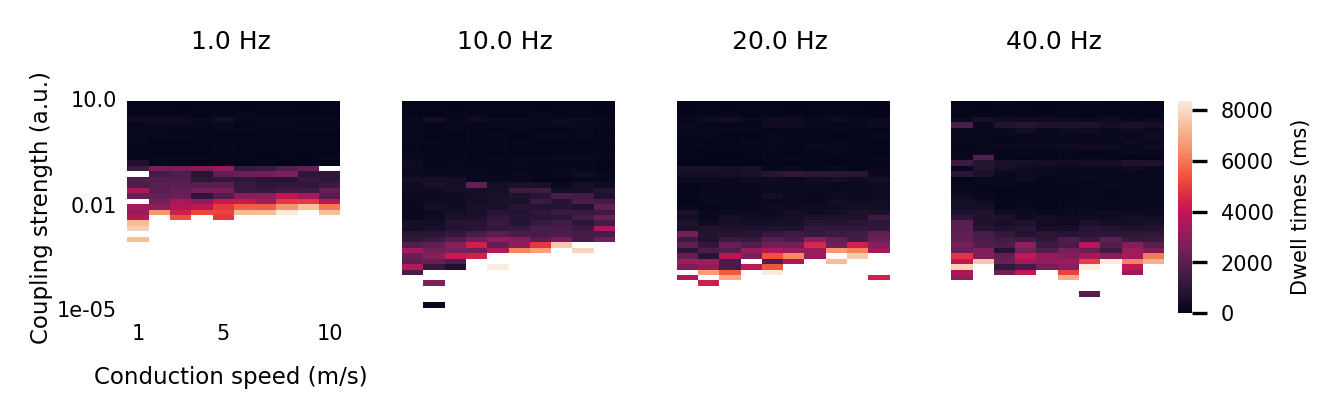

In [105]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(9.3*cm, 3*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency))


for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1,1)
    subfigs[i].subplots_adjust(top=0.8, bottom=0.2)

    p = sns.heatmap(dwell_times_freq[i], vmin=0, vmax=None, cmap=cmap, ax=ax, 
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.2, .05, .6]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Dwell times (ms)'} if i==len(intrinsic_frequency)-1 else None)    
    p.set_xlabel(None)
    p.set_ylabel(None)
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set_xticklabels(labels=[]) if i!=0 else None
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    if i==0:
        p.set_yticks(np.array([0.5, 19.5, 39]))
        p.set_xticks(np.array([0.5,4.5,9.5]))
        p.set_xticklabels([1, 5, 10], rotation=0)
        p.set(xlabel=None, ylabel=None, yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
        subfigs[i].text(0.5, 0., 'Conduction speed (m/s)', ha='center', fontsize=5.5)
        subfigs[i].text(-0.23, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize=5.5)

fig.suptitle(' ')

plt.savefig(os.path.join(figure_path, f'40_dwell_times.svg'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'40_dwell_times.png'), dpi=300, transparent=False, bbox_inches='tight')

In [128]:
# Get dwell times for best FC fit
dwell_times_alpha = np.load(os.path.join(data_path, "40_analysis_dwell_times", f"40_dwell_times_{1}_{19}_{2}.npy"))
dwell_times_beta = np.load(os.path.join(data_path, "40_analysis_dwell_times", f"40_dwell_times_{2}_{20}_{5}.npy"))
dwell_times_gamma = np.load(os.path.join(data_path, "40_analysis_dwell_times", f"40_dwell_times_{3}_{22}_{9}.npy"))

In [176]:
# Load dwell times of resting-state MEG
with open("/Users/dk/Documents/Charite/PhD/travelingwaves/data/hcp_meg/dwell_times_meg.npy", "rb") as f:
    dwell_times_meg = pickle.load(f)

In [254]:
# Kolmogorov-Smirnov Test
print(kstest(dwell_times_alpha, dwell_times_meg[0]))
print(kstest(dwell_times_beta, dwell_times_meg[1]))
print(kstest(dwell_times_gamma, dwell_times_meg[2]))

KstestResult(statistic=0.20896945252881738, pvalue=2.440422513525193e-06)
KstestResult(statistic=0.049068997252778745, pvalue=0.6712129698789209)
KstestResult(statistic=0.07688159118034385, pvalue=0.018394400989161834)


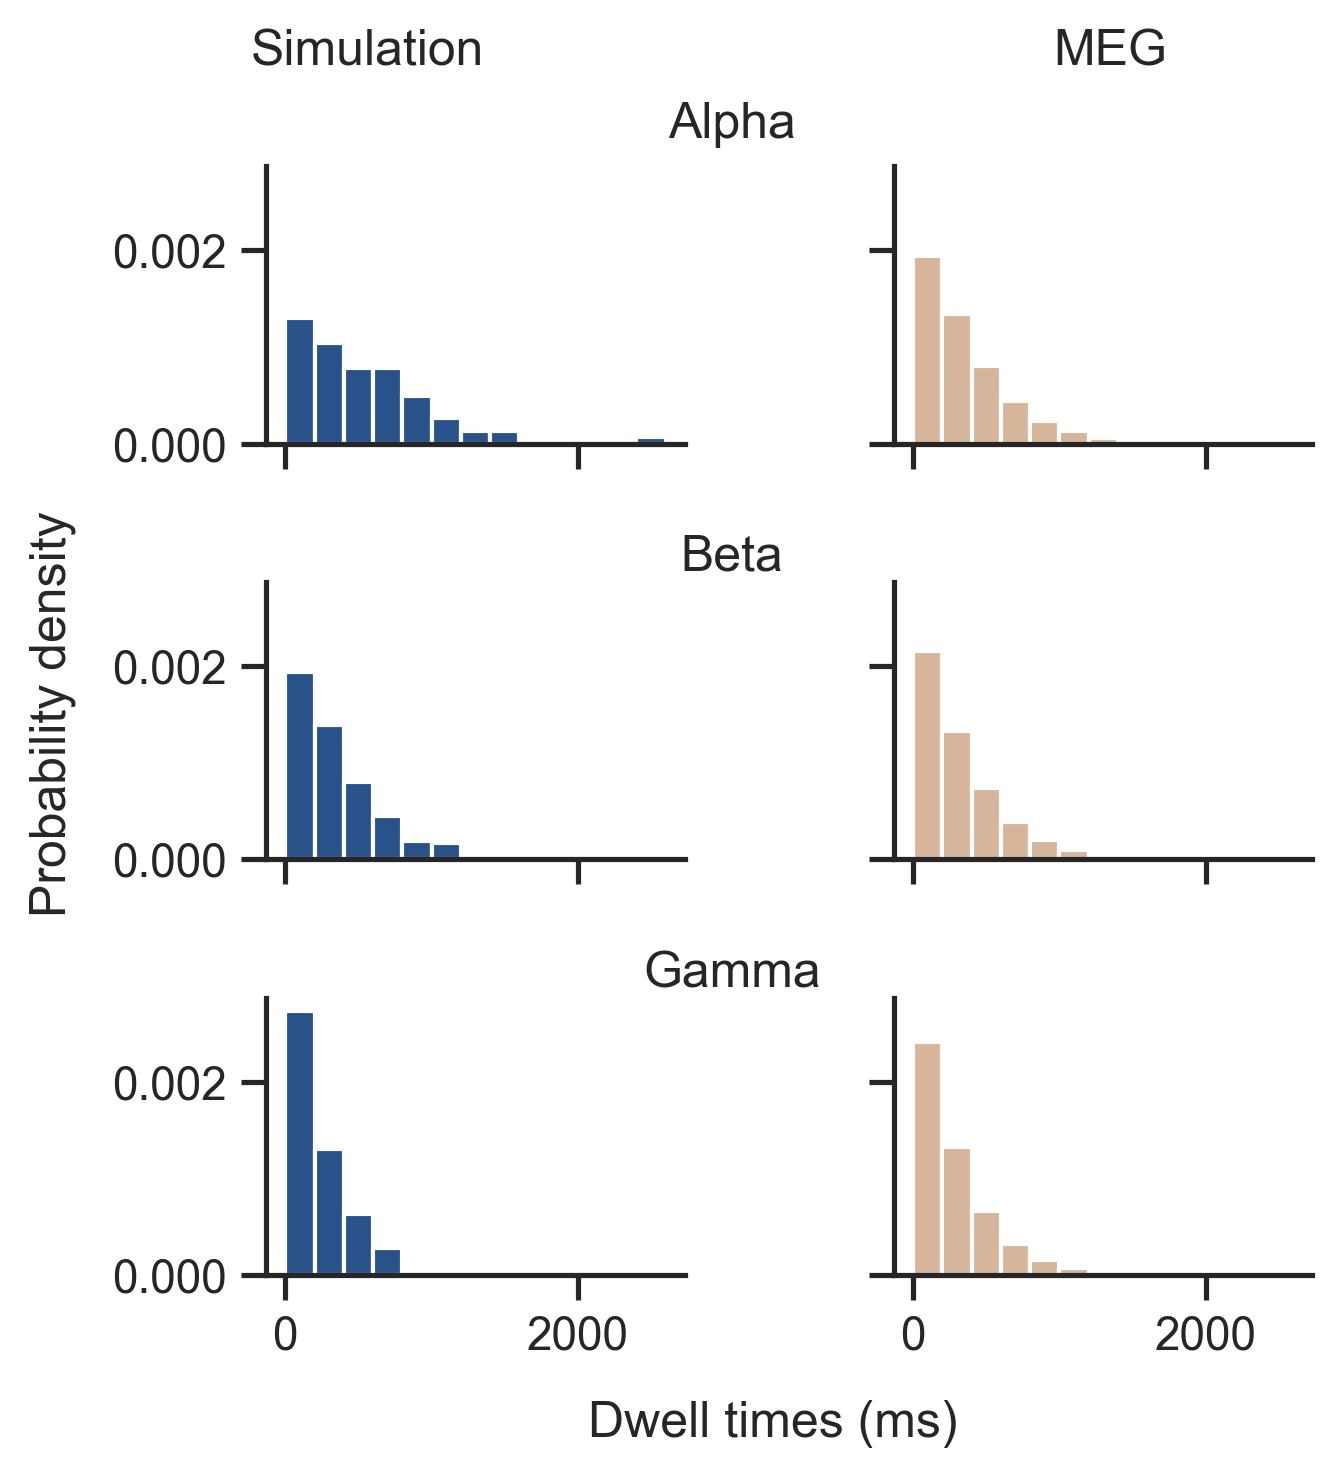

In [261]:
# plot dwell times distribution
sns.set_theme(style="ticks")
fig, ax = plt.subplots(3, 2, figsize=(4.5, 1.2*4), sharex=True, sharey=True, dpi=300)

bins = np.arange(0, 2800, 200)

fontsize=None

fig.text(.2, 0.95, 'Simulation', transform=fig.transFigure, horizontalalignment='center', fontsize=fontsize)
fig.text(.75, 0.95, 'MEG', transform=fig.transFigure, horizontalalignment='center', fontsize=fontsize)

fig.text(.47, 0.9, 'Alpha', transform=fig.transFigure, horizontalalignment='center', fontsize=fontsize)
fig.text(.47, 0.6, 'Beta', transform=fig.transFigure, horizontalalignment='center', fontsize=fontsize)
fig.text(.47, 0.31, 'Gamma', transform=fig.transFigure, horizontalalignment='center', fontsize=fontsize)


# plot Simulation dwell times distribution
ax[0,0].hist(dwell_times_alpha, bins, color='#29528a', density=True)
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].set_xticks([0, 2000])
ax[0,0].set_yticks([0, 0.002])

ax[1,0].hist(dwell_times_beta, bins, color='#29528a', density=True)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].set_xticks([0, 2000])
ax[1,0].set_yticks([0, 0.002])

ax[2,0].hist(dwell_times_gamma, bins, color='#29528a', density=True)
ax[2,0].spines['right'].set_visible(False)
ax[2,0].spines['top'].set_visible(False)
ax[2,0].set_xticks([0, 2000])
ax[2,0].set_yticks([0, 0.002])


# plot MEG dwell times distribution
ax[0,1].hist(dwell_times_meg[0], bins, color='#d6b59b', density=True)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].set_xticks([0, 2000])

ax[1,1].hist(dwell_times_meg[1], bins, color='#d6b59b', density=True)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].set_xticks([0, 2000])

ax[2,1].hist(dwell_times_meg[2], bins, color='#d6b59b', density=True)
ax[2,1].spines['right'].set_visible(False)
ax[2,1].spines['top'].set_visible(False)
ax[2,1].set_xticks([0, 2000])

fig.supxlabel('Dwell times (ms)', y=-0.01, fontsize=fontsize)
fig.supylabel('Probability density', x=-0.05, fontsize=fontsize)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

#plt.savefig(os.path.join(figure_path, '40_dwell_times_histogram.png'), dpi=300, transparent=False, bbox_inches='tight')
#plt.savefig(os.path.join(figure_path, '40_dwell_times_histogram.svg'), dpi=300, transparent=False, bbox_inches='tight')

In [96]:
# dwell times for best FC fit
print(f'dwell times for best FC fit in the alpha band: {dwell_times_freq[1].iloc[19,2]}')
print(f'dwell times for best FC fit in the beta band: {dwell_times_freq[2].iloc[20,5]}')
print(f'dwell times for best FC fit in the gamma band: {dwell_times_freq[3].iloc[22,9]}')

dwell times for best FC fit in the alpha band: 430.0
dwell times for best FC fit in the beta band: 255.0
dwell times for best FC fit in the gamma band: 170.0


### Metastability Synchronization Order Parameter

In [76]:
sync_order_parameter = []
for frequency_idx, freq in enumerate(intrinsic_frequency):
    for coupling_strength_idx, coupling in enumerate(coupling_strength):
        for conduction_speed_idx, speed in enumerate(conduction_speed):
            sync_order_parameter_tmp = np.median(np.load(os.path.join(data_path, "40_analysis_metastability", f"40_sync_sd_{frequency_idx}_{coupling_strength_idx}_{conduction_speed_idx}.npy")))
            sync_order_parameter.append([freq, coupling*1000, speed, sync_order_parameter_tmp])

In [77]:
# guided waves
# ------------
# build dataframe
sync_order_parameter_stats = pd.DataFrame(sync_order_parameter, columns=['frequency', 'coupling strength', 'conduction speed', 'sync SD'])

# average across simulations
sync_order_parameter_stats_avg = sync_order_parameter_stats.groupby(['frequency', 'coupling strength', 'conduction speed']).mean()


# Aggregate metrics
# -----------------
sync_order_parameter_freq = []

for i, fq in enumerate(intrinsic_frequency):  
    # guided waves correlation per frequency
    sync_order_parameter_freq.append(sync_order_parameter_stats_avg.query(f'frequency=={fq}').pivot_table(index='coupling strength', 
                                                                                       columns='conduction speed', 
                                                                                       values='sync SD',
                                                                                       dropna=False)
                           )

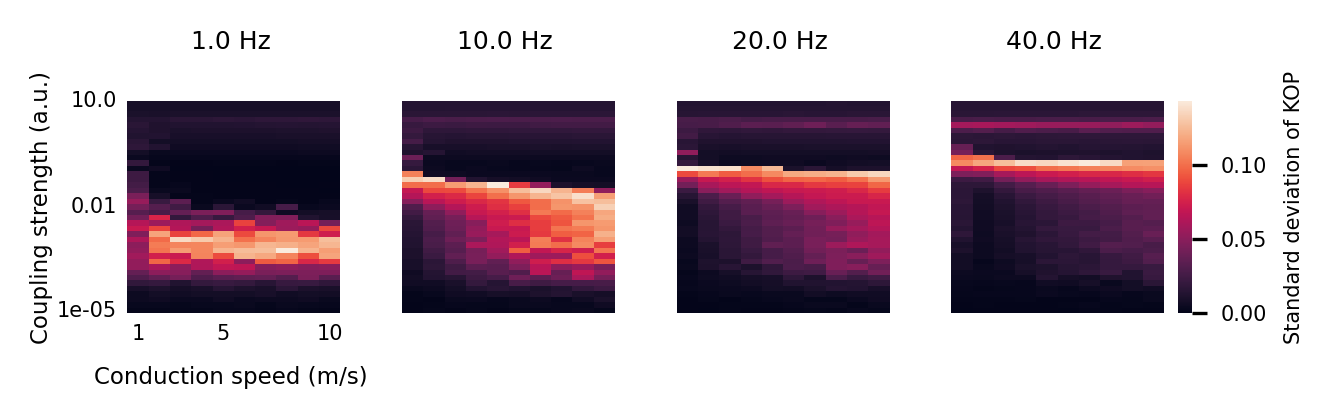

In [104]:
# Assemble figure
cm = 1/2.54  # centimeters in inches
plt.rcParams.update({'font.size': 5})

cmap = sns.color_palette("rocket", as_cmap=True)

# create figure
fig = plt.figure(figsize=(9.3*cm, 3*cm), dpi=300)
subfigs = fig.subfigures(1,len(intrinsic_frequency))


for i, fq in enumerate(intrinsic_frequency):
    subfigs[i].suptitle(f'{fq} Hz', y=1.)
    
    ax = subfigs[i].subplots(1,1)
    subfigs[i].subplots_adjust(top=0.8, bottom=0.2)

    p = sns.heatmap(sync_order_parameter_freq[i], vmin=0, vmax=None, cmap=cmap, ax=ax, 
                    cbar = True if i==len(intrinsic_frequency)-1 else None,
                    cbar_ax = subfigs[i].add_axes([.95, 0.2, .05, .6]) if i==len(intrinsic_frequency)-1 else None, 
                    cbar_kws={'label': 'Standard deviation of KOP'} if i==len(intrinsic_frequency)-1 else None)    
    p.set_xlabel(None)
    p.set_ylabel(None)
    p.set_yticklabels(labels=[]) if i!=0 else None
    p.set_xticklabels(labels=[]) if i!=0 else None
    p.invert_yaxis()
    p.tick_params(left=False, bottom=False, pad=-1)
    
    if i==0:
        p.set_yticks(np.array([0.5, 19.5, 39]))
        p.set_xticks(np.array([0.5,4.5,9.5]))
        p.set_xticklabels([1, 5, 10], rotation=0)
        p.set(xlabel=None, ylabel=None, yticklabels=[coupling_strength[0]*1000, coupling_strength[19]*1000, coupling_strength[-1]*1000])
        subfigs[i].text(0.5, 0., 'Conduction speed (m/s)', ha='center', fontsize=5.5)
        subfigs[i].text(-0.23, .5, 'Coupling strength (a.u.)', va='center', rotation='vertical', fontsize=5.5)

fig.suptitle(' ')

plt.savefig(os.path.join(figure_path, f'40_metastability.svg'), dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(os.path.join(figure_path, f'40_metastability.png'), dpi=300, transparent=False, bbox_inches='tight')

In [79]:
# find maximum synchronization order parameter variance
print(np.where(sync_order_parameter_freq[1]==np.max(sync_order_parameter_freq[1])))
print(np.max(sync_order_parameter_freq[1]))

(array([23]), array([4]))

In [87]:
# SD(KOP) for best FC fit
print(f'SD(KOP) for best FC fit in the alpha band: {sync_order_parameter_freq[1].iloc[19,2]}')
print(f'SD(KOP) for best FC fit in the beta band: {sync_order_parameter_freq[2].iloc[20,5]}')
print(f'SD(KOP) for best FC fit in the gamma band: {sync_order_parameter_freq[3].iloc[22,9]}')

SD(KOP) for best FC fit in the alpha band: 0.06724670734725999
SD(KOP) for best FC fit in the beta band: 0.06093369173075164
SD(KOP) for best FC fit in the gamma band: 0.04830126180652875
